
## Introducción
La empresa Sweet Lift Taxi busca optimizar la asignación de taxis durante las horas pico en aeropuertos. Para ello, es crucial contar con un modelo predictivo que anticipe la cantidad de pedidos de taxis en la próxima hora, permitiendo tomar decisiones operativas basadas en datos.

En este proyecto, construiremos y evaluaremos modelos de Machine Learning para predecir el número de pedidos por hora. Se utilizarán series temporales con características extraídas de los datos históricos, y los modelos serán evaluados según la métrica RMSE (Raíz del Error Cuadrático Medio). El RMSE en el conjunto de prueba debe ser menor o igual a 48 para cumplir con el objetivo.


## Objetivos
1  Preparar los datos:
- Remuestrear los datos a intervalos horarios.
- Crear características relevantes (lags y medias móviles).
- Dividir los datos en conjuntos de entrenamiento, validación y prueba.

2 Entrenar modelos predictivos:
- Probar diferentes algoritmos (Regresión Lineal y Bosque Aleatorio).
- Ajustar hiperparámetros para optimizar el rendimiento.

3 Evaluar el modelo:
- Comparar los modelos en términos de RMSE en los conjuntos de validación y prueba.
- Seleccionar el modelo final y validar su rendimiento.

4 Proporcionar recomendaciones basadas en los resultados.

## Importación de bibliotecas y carga de datos

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
# Cargar datos
df = pd.read_csv('datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [15]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [16]:
# Remuestrear los datos a intervalos de una hora
df = df.resample('H').sum()
# Verificar los datos remuestreados
df.head()

C:\Users\juan6\AppData\Local\Temp\ipykernel_5440\1678921203.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Exploración y análisis de datos

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


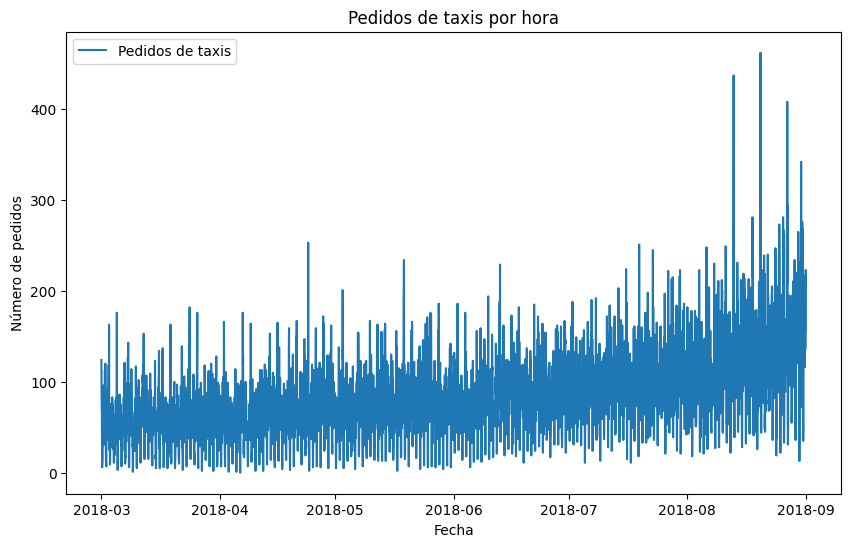

In [17]:
# Descripción estadística básica
print(df.describe())

# Visualización de los datos
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['num_orders'], label='Pedidos de taxis')
plt.title('Pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.show()

## Creación de características

In [18]:
# Función para crear características
def make_features(data, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek >= 5

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

# Crear características
make_features(df, max_lag=24, rolling_mean_size=12)

# Eliminar filas con valores NaN generados por el `shift()`
df = df.dropna()
df.head()

,num_orders,hour,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,False,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.583333
2018-03-02 01:00:00,120,1,4,False,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.583333
2018-03-02 02:00:00,75,2,4,False,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,68.916667
2018-03-02 03:00:00,64,3,4,False,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.166667
2018-03-02 04:00:00,20,4,4,False,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,71.000000


## División de los datos

In [19]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
train_data, temp_data = train_test_split(df, test_size=0.2, shuffle=False)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

# Separar características y objetivo
X_train = train_data.drop(['num_orders'], axis=1)
y_train = train_data['num_orders']
X_validation = validation_data.drop(['num_orders'], axis=1)
y_validation = validation_data['num_orders']
X_test = test_data.drop(['num_orders'], axis=1)
y_test = test_data['num_orders']

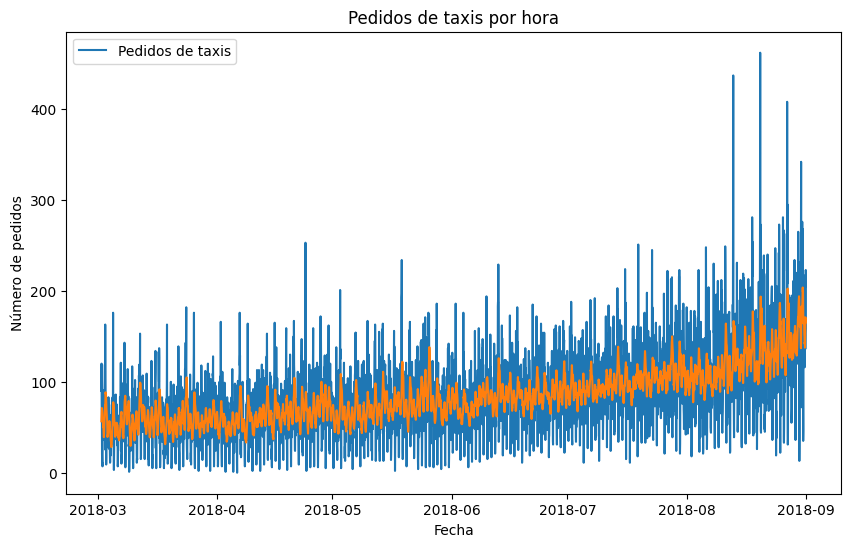

In [20]:
# Visualización de los datos

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['num_orders'], label='Pedidos de taxis')
plt.plot(df.index, df['rolling_mean'])
plt.title('Pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.show()

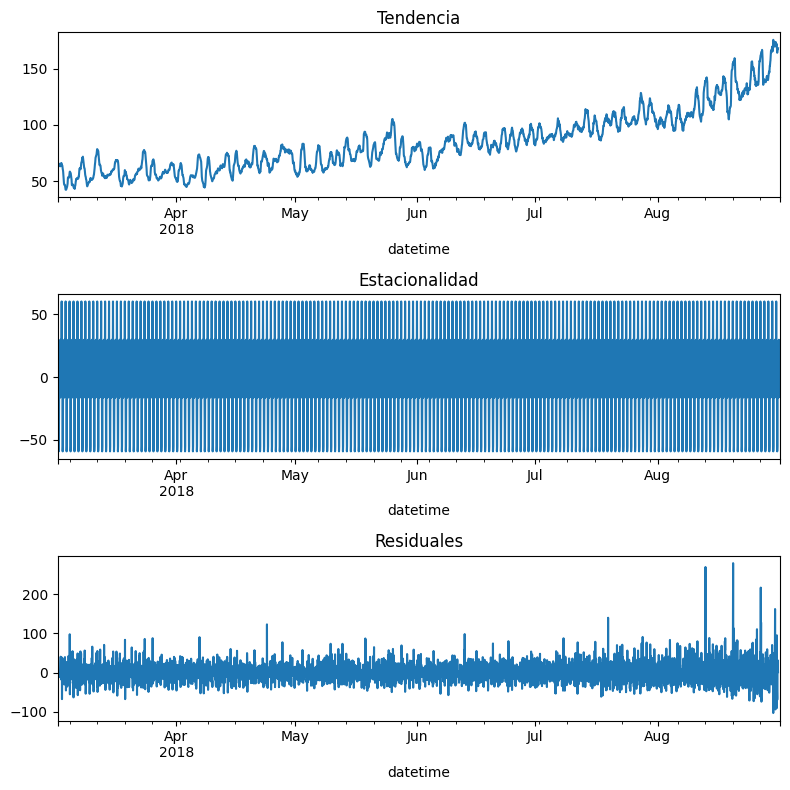

In [21]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')
plt.tight_layout()

<Axes: xlabel='datetime'>

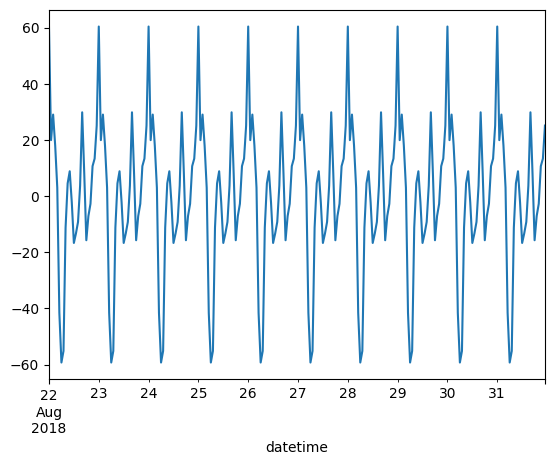

In [22]:
decomposed.seasonal['2018-08-22':'2018-08-31'].plot()

## Entrenamiento y evaluación de modelos

In [23]:
# Regresión Lineal

# Entrenamiento y evaluación en el conjunto de validación
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

predictions_valid = model_lr.predict(X_validation)

rmse_lr_valid = mean_squared_error(y_validation, predictions_valid)**0.5
print(f'Regresión Lineal - RMSE en validación: {rmse_lr_valid:.2f}')

# Evaluación final en el conjunto de prueba
predictions_test = model_lr.predict(X_test)
rmse_lr_test = mean_squared_error(y_test, predictions_test)**0.5
print(f'Regresión Lineal - RMSE en prueba: {rmse_lr_test:.2f}')

Regresión Lineal - RMSE en validación: 34.30
Regresión Lineal - RMSE en prueba: 45.57


In [ ]:
# Bosque Aleatorio
best_rmse_rf = float("inf")
best_depth_rf = 0

for depth in range(10, 21):
    model_rf = RandomForestRegressor(n_estimators=150, max_depth=depth, random_state=485)
    model_rf.fit(X_train, y_train)

    predictions_valid = model_rf.predict(X_validation)

    rmse = mean_squared_error(y_validation, predictions_valid)**0.5
    if rmse < best_rmse_rf:
        best_rmse_rf = rmse
        best_depth_rf = depth

    print(f'Random Forest max_depth={depth} RMSE en validación: {rmse:.2f}')

# Evaluación final del mejor Bosque Aleatorio en el conjunto de prueba
model_rf = RandomForestRegressor(n_estimators=150, max_depth=best_depth_rf, random_state=485)
model_rf.fit(X_train, y_train)
predictions_test_rf = model_rf.predict(X_test)
rmse_rf_test = mean_squared_error(y_test, predictions_test_rf)**0.5
print(f'Random Forest - RMSE en prueba: {rmse_rf_test:.2f}')

Random Forest max_depth=10 RMSE en validación: 32.51
Random Forest max_depth=11 RMSE en validación: 32.18
Random Forest max_depth=12 RMSE en validación: 32.10


## Evaluación final

In [24]:
# Evaluar en el conjunto de prueba usando el mejor modelo:

# Modelo regresion lineal
rmse_lr_test = mean_squared_error(y_test, predictions_test)**0.5
print(f'Regresión Lineal - RMSE en prueba: {rmse_lr_test:.2f}')


# Modelo bosque aleatorio 
rmse_rf_test = mean_squared_error(y_test, predictions_test_rf)**0.5
print(f'Random Forest - RMSE en prueba: {rmse_rf_test:.2f}')

Regresión Lineal - RMSE en prueba: 45.57
Random Forest - RMSE en prueba: 49.11


## Conclusiones
1 Modelos probados:
- Regresión Lineal: RMSE en prueba = 45.57.
- Bosque Aleatorio: RMSE en prueba = 49.11.

2 Modelo seleccionado:
- La Regresión Lineal tuvo un RMSE más bajo (45.57), lo que la convierte en el modelo más adecuado para este problema.

3 Las características derivadas como la hora del día, el día de la semana y si es fin de semana fueron fundamentales para capturar patrones temporales en los datos. Esto permitió a los modelos comprender las fluctuaciones en la demanda de taxis según el tiempo.

4 La media móvil ayudó a suavizar las fluctuaciones aleatorias y resaltó las tendencias a largo plazo en los datos. Esto resultó en un mejor comportamiento del modelo, especialmente en períodos donde los datos presentaban ruido.

5 Aunque el modelo de Bosque Aleatorio (Random Forest) suele ser más flexible y capaz de captar relaciones no lineales, en este caso, la Regresión Lineal tuvo un mejor desempeño en el conjunto de prueba, sugiriendo que la relación entre las características y la variable objetivo es predominantemente lineal.

6 Próximos pasos:
- Implementar el modelo en producción para predecir la demanda horaria de taxis.
- Continuar recopilando datos para mejorar el rendimiento del modelo en el futuro.

## Recomendaciones

1- Monitoreo y actualización del modelo:

- Implementar un sistema de monitoreo para evaluar periódicamente el rendimiento del modelo. Si el RMSE empieza a aumentar, es posible que el modelo necesite ser reentrenado con datos más recientes.

2- Evaluar otros modelos:

- Probar modelos más avanzados como XGBoost o LightGBM, que suelen tener un mejor rendimiento en problemas de series temporales. También considerar enfoques híbridos que combinen modelos de aprendizaje automático con técnicas estadísticas.

3- Toma de decisiones basadas en predicciones:

- Usar las predicciones del modelo para implementar estrategias de incentivos a los conductores en las horas pico y así reducir los tiempos de espera de los clientes.